In [2]:
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.constants import c, k_B #import the light velocity and Boltzmann constant
from astropy import units as u

#Define the constants
c = c.to(u.km/u.s).value #speed of light in km/s
k = k_B.to(u.J/u.K).value #Boltzmann constant in J/K

# Open the FITS file and review the header
with fits.open("member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits") as hdul:
    # Print a summary of the FITS file
    print("FITS File Summary:")
    hdul.info()

    # Loop through each HDU to inspect headers and data
    for i, hdu in enumerate(hdul):
        print(f"\nHDU {i} Header:")
        print(repr(hdu.header))  # Print the header of the HDU

        # Check if the HDU contains data
        if hdu.data is not None:
            print(f"HDU {i} Data Shape: {hdu.data.shape}")
        else:
            print(f"HDU {i} contains no data.")
    


FITS File Summary:
Filename: member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     426   (120, 128, 2043, 1)   float32   

HDU 0 Header:
SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  120                                                  
NAXIS2  =                  128                                                  
NAXIS3  =                 2043                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.0000000

# __FREQ TO RADIAL VELOCITY__

To convert Frequency to Velocity, in radio astronomy it is necessary to know that, the ALMA data deliver a _Resting Frequency_, which refers to the intrinsic frequency where the spectral line emitted in the emitter reference systems, before some relative motion effect, such as __Doppler effect__ (redshift).

## Doppler Effect
$$ v = c (\frac{\lambda_{rest} - \lambda}{\lambda_{rest}})$$

where: 
- $\lambda_{rest}$ : Rest Freq. (Hz)
- $\lambda$ : Freq. (Hz)
- c : Light velocity (km/s)
- v : velocity (km/s)

Python have a equivalencies for this; using doopler_radio()

### NOTE:
Each axis in the data file contains three parameters to extract: __CRVAL__ ,__CDET__ y__CRPIX__. Do I extract all information about each channel, I applied an extraction format given by: 
$$AX = CRVAL + (NAXIS - CRPIX) * CDELT$$

where: 
- CRVAL: El valor de referencia del eje (frecuencia de referencia en este caso en el primer pixel).
- CDELT: El incremento en el valor de la coordenada fisica entre los pixeles consecutivos.
- CRPIX: El indice del pixel de referencia (indice donde se encuentra el valor de referencia)
- NAXIS: Numero total de canales en el eje

In [3]:

#open again the data
hdul = fits.open("member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits")

hdu = hdul[0]
data = hdu.data
header = hdu.header
wcs = WCS(header)

#extract the necessesary information
RESTFREQ = header["RESTFRQ"] * u.Hz #applied into Doppler effect
CRVAL_3 = header["CRVAL3"]
CRPIX_3 = header["CRPIX3"]
CDELT_3 = header["CDELT3"]
NAXIS_3 = header["NAXIS3"]

#use the format to get all inf. of frequency axis
FREQ_AX = CRVAL_3 + (np.arange(NAXIS_3) - CRPIX_3) * CDELT_3
#print(len(FREQ_AX))
FREQ = FREQ_AX * u.Hz #Frequecy axis in Hz
print(FREQ)

#applied the Doppler effect formula to get the velocity axis
#VEL = c * (RESTFREQ - FREQ) / RESTFREQ #velocity axis in km/s
#VEL = FREQ.to(u.km / u.s, equivalencies=u.doppler_radio(RESTFREQ))

#print(f"Velocity axis in km/s:{VEL}")

current_beam = hdul.beam
c_resolution = current_beam.major.to(u.arcsec)
print(f"Resolución actual: {c_resolution}")
#######Falta guardar la informacion

[1.02382355e+11 1.02382477e+11 1.02382599e+11 ... 1.02631405e+11
 1.02631527e+11 1.02631649e+11] Hz


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


AttributeError: 'HDUList' object has no attribute 'beam'

# Flux Density - Brightnes Temperature Conversion

To do realice this conversion, I based in the __Rayleigh - Jeans equation__ :

$$ S = \frac{2kT_{MB}\Omega}{\lambda^{2}} $$

where: 
- S: Flux density (Jy)
- k: Boltzmann constant
- $T_{MB}$: Brigthness temperature (K)
- $\Omega$: Beam solid angle
- $\lambda$: Wavelenght

__Note__: Beam solid angle is in radians, no angle. The area of Gaussian beam is define by its 2-dimensional integral:

$$ \Omega = \frac{\pi \theta_{maj}\theta_{min}}{4ln(2)} $$

If is necesarry transform angle to radians: 1 grade = 3600 arcsec

__NOTE__: Can use brightness_temperature()

In [ ]:
#extract the Beam information
B_MAJ = header["BMAJ"] * u.deg
B_MIN = header["BMIN"] * u.deg

#print(B_MAJ, B_MIN)
BMAJ_RAD = B_MAJ.to(u.rad)  # Convertir a radianes
BMIN_RAD = B_MIN.to(u.rad)  # Convertir a radianes

#print(BMAJ_RAD, BMIN_RAD)
#calculate the Omega
B_AREA = (np.pi * BMAJ_RAD * BMIN_RAD) / (4 * np.log(2))
#print(B_AREA)

#Applied Rayleigth-Jeans law
equiv = u.brightness_temperature(RESTFREQ, B_AREA)
print(type(equiv))

Tmb = (data * u.Jy).to(u.K, equivalencies=equiv) # Convertir los datos de Jy/beam a Kelvin
#revisar la operacion, generar un numnero ficticio y revisar la transfor.
print(Tmb)
######falta guardar la info


<class 'astropy.units.equivalencies.Equivalency'>
[[[[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]]

  [[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]]

  [[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]]

  ...

  [[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]]

  [[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan n

In [18]:
## Guardar los nuestros datos en un nuevo archivo FITS, Tmb y Vel

#Create a new HEADER
NEWHEADER = header.copy()

NEWHEADER["CRVAL3"] = VEL[0].value  # Cambiar el valor de referencia de la coordenada a la primera velocidad
NEWHEADER["CDELT3"] = (VEL[1] - VEL[0]).value  # Cambiar la resolución de la coordenada a la diferencia entre dos velocidades consecutivas
NEWHEADER["CTYPE3"] = "VELO-LSR"  # Cambiar el tipo de coordenada a velocidad
NEWHEADER["CUNIT3"] = "km/s"  # Cambiar la unidad de la coordenada a km/s

NEWHEADER["BUNIT"] = "K"  # Cambiar la unidad a Kelvin

#Save the new datas and header in new file.FITS
fits.writeto("TmbandVEL.fits", Tmb.value, NEWHEADER, overwrite=True)
hdul.close()


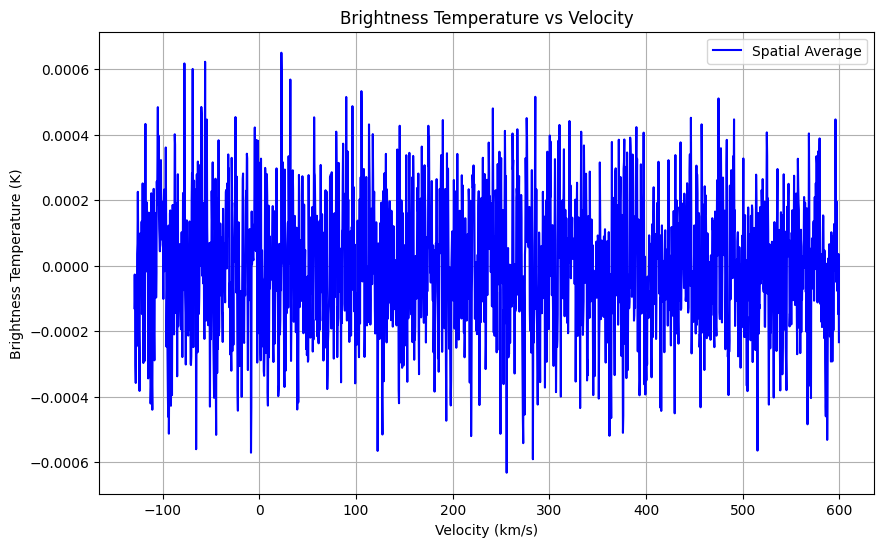

In [7]:
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
import astropy.units as u

# Load the spectral cube from a FITS file
cube = SpectralCube.read("TmbandVEL.fits", use_dask=True)  # Replace with your FITS file name

# Convert the spectral axis to velocity (if not already in km/s)
cube = cube.with_spectral_unit(u.km / u.s)

# Extract the velocity axis
vel = cube.spectral_axis.value  # Velocity axis in km/s

# Compute the spatial average of Tmb (Brightness Temperature) for each velocity channel
Tmb_avg = cube.mean(axis=(1, 2)).value  # Average over RA and DEC

# Plot Tmb vs Velocity
plt.figure(figsize=(10, 6))
plt.plot(vel, Tmb_avg, color="blue", label="Spatial Average")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Brightness Temperature (K)")
plt.title("Brightness Temperature vs Velocity")
plt.legend()
plt.grid()
plt.show()
##cube[1015, : , :].quicklook()  # Plotear un canal del cubo
#print(cube.stokes) -----Revisar esto a profundidad
#print(cube.wcs) ------Fijarse como esta dado el WCS y que se aplique

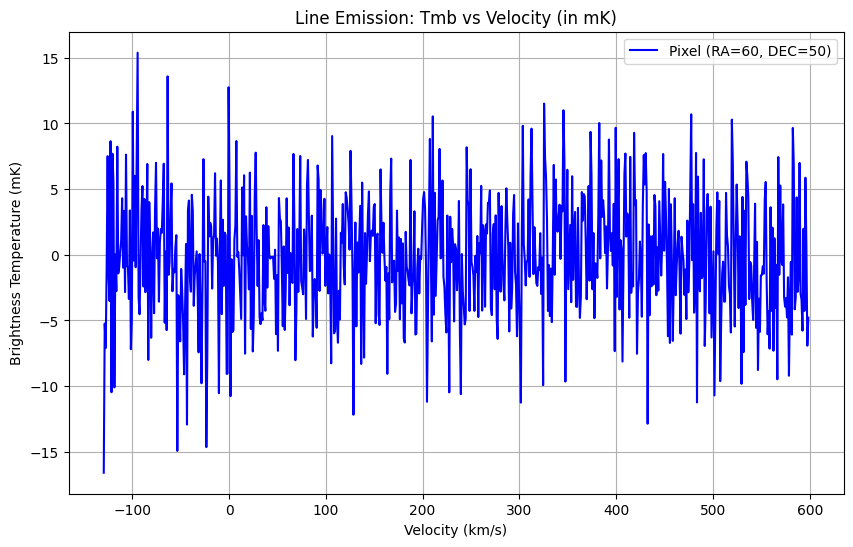

In [3]:
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
import astropy.units as u

# Cargar el cubo espectral desde un archivo FITS
cube = SpectralCube.read("CUBE_RESAMPLED_SPECTRAL.fits", use_dask=True)  # Reemplaza con el nombre de tu archivo FITS

# Convertir el eje espectral a velocidades (si no está ya en km/s)
cube = cube.with_spectral_unit(u.km / u.s)

# Extraer el eje de velocidades
velocities = cube.spectral_axis.value  # Eje de velocidades en km/s

# Seleccionar un píxel específico (RA, DEC)
ra_idx = 60  # Índice en el eje RA
dec_idx = 50  # Índice en el eje DEC
Tmb_pixel = cube[:, dec_idx, ra_idx].value  # Extraer el espectro para el píxel

# Convertir Tmb de Kelvin a miliKelvin
Tmb_pixel_mK = Tmb_pixel * 1e3  # Transformar a mK

# Graficar Tmb vs Vel para el píxel seleccionado
plt.figure(figsize=(10, 6))
plt.plot(velocities, Tmb_pixel_mK, label=f"Pixel (RA={ra_idx}, DEC={dec_idx})", color="blue")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Brightness Temperature (mK)")
plt.title("Line Emission: Tmb vs Velocity (in mK)")
plt.legend()
plt.grid()
plt.show()

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3                                                  NAXIS1  =                  120                                                  NAXIS2  =                  128                                                  NAXIS3  =                  731                                                  BMAJ    =   4.442253420057E-03                                                  BMIN    =   3.226777089219E-03                                                  BPA     =  -8.550686982140E+01                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'N159-13CII'                                                          BUNIT   = 'Jy beam-1'          / Brightness (pixel) unit                        ALTRVAL =   5.990705566226E+05 /Alternat

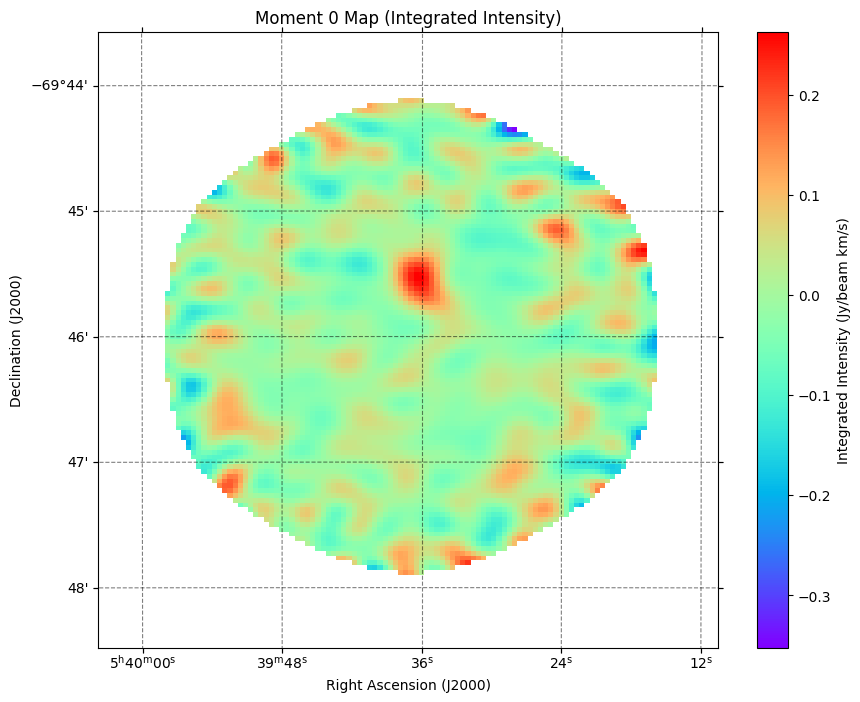

In [4]:
##Use moments maps to get the information about emission distribution

#MOment 0, integrated intensity
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
import astropy.units as u


from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord

# Cargar el cubo espectral desde un archivo FITS
#cube = SpectralCube.read("CUBE_RESAMPLED_SPECTRAL.fits")  # Reemplaza con el nombre de tu archivo FITS
cube = SpectralCube.read("CUBE_SPEC_RESAM.fits")  # Reemplaza con el nombre de tu archivo FITS
print(cube.header)


# Convertir el eje espectral a velocidades (si no está ya en km/s)
cube = cube.with_spectral_unit(u.km / u.s)

# Definir un rango de velocidades (opcional)
vel_min = 225 * u.km / u.s  # Velocidad mínima
vel_max = 245 * u.km / u.s  # Velocidad máxima
subcube = cube.spectral_slab(vel_min, vel_max)  # Crear un subcubo con el rango de velocidades

# Calcular el momento 0 (intensidad integrada)
moment_0 = subcube.moment(order=0)  # Momento 0 en unidades de K * km/s
wcs = moment_0.wcs


# Visualizar el momento 0
plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)  # Usar WCS para los ejes
im = ax.imshow(moment_0.value, origin='lower', cmap='rainbow', aspect='auto')
plt.colorbar(im, label="Integrated Intensity (Jy/beam km/s)")
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.title("Moment 0 Map (Integrated Intensity)")
plt.grid(color='black', linestyle='--', alpha=0.5)
plt.show()

In [43]:
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.constants import c, k_B #import the light velocity and Boltzmann constant
from astropy import units as u

with fits.open("N159_CII_map.fits") as hdul:
    # Print a summary of the FITS file
    print("FITS File Summary:")
    hdul.info()

    # Loop through each HDU to inspect headers and data
    for i, hdu in enumerate(hdul):
        print(f"\nHDU {i} Header:")
        print(repr(hdu.header))  # Print the header of the HDU

        # Check if the HDU contains data
        if hdu.data is not None:
            print(f"HDU {i} Data Shape: {hdu.data.shape}")
        else:
            print(f"HDU {i} contains no data.")

FITS File Summary:
Filename: N159_CII_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (58, 59, 300)   float64   

HDU 0 Header:
SIMPLE  =                    T / Written by IDL:  Tue Mar 28 14:54:01 2017      
BITPIX  =                  -64 / Number of bits per data pixel                  
NAXIS   =                    3 / Number of data axes                            
NAXIS1  =                   58 /                                                
NAXIS2  =                   59 /                                                
NAXIS3  =                  300 /                                                
DATE    = '2017-03-28'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
CTYPE1  = 'RA---TAN'           / Coordinate Type                              

In [46]:
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
import astropy.units as u
import numpy as np
from reproject import reproject_interp

# Cargar el primer archivo FITS (TmbandVEL.fits)
cube1 = SpectralCube.read("TmbandVEL.fits")  # Reemplaza con la ruta correcta
cube1 = cube1.with_spectral_unit(u.km / u.s)

# Definir un rango de velocidades para el primer archivo
vel_min1 = 232 * u.km / u.s  # Velocidad mínima
vel_max1 = 241 * u.km / u.s  # Velocidad máxima
subcube1 = cube1.spectral_slab(vel_min1, vel_max1)

# Calcular el momento 0 (intensidad integrada) para el primer archivo
moment_0_1 = subcube1.moment(order=0)  # Intensidad integrada en K km/s

# Cargar el segundo archivo FITS (N159_CII_map.fits)
cube2 = SpectralCube.read("N159_CII_map.fits")  # Reemplaza con la ruta correcta
cube2 = cube2.with_spectral_unit(u.km / u.s)

# Definir un rango de velocidades para el segundo archivo
vel_min2 = 232 * u.km / u.s  # Velocidad mínima
vel_max2 = 241 * u.km / u.s  # Velocidad máxima
subcube2 = cube2.spectral_slab(vel_min2, vel_max2)

# Calcular el momento 0 (intensidad integrada) para el segundo archivo
moment_0_2 = subcube2.moment(order=0)  # Intensidad integrada en K km/s

# Extraer el WCS 2D de los mapas del momento 0
wcs1 = moment_0_1.wcs
wcs2 = moment_0_2.wcs

# Reproyectar el segundo mapa al WCS del primero (si las dimensiones no coinciden)
if moment_0_1.shape != moment_0_2.shape:
    moment_0_2_reprojected, _ = reproject_interp((moment_0_2, wcs2), wcs1, shape_out=moment_0_1.shape)
else:
    moment_0_2_reprojected = moment_0_2

# Normalizar ambos mapas por su mediana
moment_0_1_normalized = moment_0_1.value / np.nanmedian(moment_0_1.value)
moment_0_2_normalized = moment_0_2_reprojected / np.nanmedian(moment_0_2_reprojected)

# Aplanar los datos para el scatter plot
x = moment_0_1_normalized.flatten()
y = moment_0_2_normalized.flatten()

# Filtrar valores NaN o infinitos
valid = np.isfinite(x) & np.isfinite(y)
x = x[valid]
y = y[valid]

# Generar el scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, s=10, color="blue", label="Normalized Intensities")
plt.xlabel("CF Normalized Intensity")
plt.ylabel("CII Normalized Intensity")
plt.title("Scatter Plot of Normalized Integrated Intensities")
plt.legend()
plt.grid()
plt.show()

InvalidSubimageSpecificationError: ERROR 12 in wcssub() at line 913 of file cextern\wcslib\C\wcs.c:
Invalid subimage specification.


# Para el diagrama rotacional, no scatterplot
Se crea un sub cubo, donde se tenga la emision de CF+ definiendo un rango de velocidad a los canales correspondientes, para ello se utiliza .spectral_slab()

VEL Range = 232 to 241

In [ ]:
##Creating a sub Cube 
#Selecting the Velocity range of the emission
VEMISSION = []


#Starting to form the plot